In [1]:
!pip install tensorflow-gpu==2.0.0-rc0
!pip install bayesian-optimization
!pip install -q tensorflow-hub
!pip install -q seaborn

     |████████████████████████████████| 380.5MB 130kB/s 
     |████████████████████████████████| 4.3MB 33.5MB/s 
     |████████████████████████████████| 501kB 39.8MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=6b4ea9ce3a94cc77f7c3621190ff37d35a07434867af9124169723d077093c1b
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import tensorflow as tf

tf.executing_eagerly()

print(tf.__version__)

2.0.0-rc0


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Reshape, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#from keras import backend as K
import numpy as np
import codecs
import csv
from sklearn.model_selection import train_test_split
from tqdm import trange
from bayes_opt import BayesianOptimization
import pickle
import os
from pathlib import Path
import tensorflow.keras.models as models
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import random

In [0]:
env_url = Path('/content/drive/My Drive/TP-final-SI')

embedding_dim = 300
max_lenght = 70
trunc_type = 'post'
oov_tok = '<00V>'

In [0]:
def save_tokenizer(tokenizer, url = 'tokenizer.pickle'):
  # saving
  with open(url, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
def load_tokenizer(url = 'tokenizer.pickle'):
  with open(url, 'rb') as handle:
    tokenizer = pickle.load(handle)
  return tokenizer

In [0]:
file_url = env_url/'dataSetUserStoriesRecognition-tunend1.csv'

######LOADING FILE
csvfile = codecs.open(file_url, 'r', encoding='utf-8', errors='ignore')
reader = csv.DictReader(csvfile, delimiter=';')

data = []
labels = []

for row in reader:
  data.append(row['Resumen'].lower())
  labels.append(int(row['Class'].lower()))

#print(len(data))
#print(len(labels))
csvfile.close()

In [0]:
del csvfile
del reader

In [0]:
#####SPLIT TRAINING-VALIDATION
data_train, data_test, labels_train, labels_test = train_test_split(
    data, labels, test_size = 0.3,
    train_size = 0.7, shuffle = 1, random_state=42,  stratify=labels
)

In [0]:
tokenizer = Tokenizer(oov_token = oov_tok)

#####TOKENIZING VOCAB
tokenizer.fit_on_texts(data)
total_words = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index

vocab_size = total_words

tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_lenght} # <= because tokenizer is 1 indexed 
#tokenizer.word_index[tokenizer.oov_token] = max_lenght + 1

####TOKENIZING TRAINING SEQUENECES
sequences = tokenizer.texts_to_sequences(data_train)
padded = pad_sequences(sequences, maxlen=max_lenght, truncating=trunc_type)

#print(sequences)

####TOKENIZING TEST SEQUENECES
testing_sequences = tokenizer.texts_to_sequences(data_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_lenght)

save_tokenizer(tokenizer, format(env_url/'tokenizer.pickle'))

In [0]:
def build_and_train_model(lstm_layers = 300, dropout_rate = 0.1, learning_rate = 0.01,
                batch_s = 25, verbose = 0, save_model = bool(0), epchs = 10, optimize = False):  
  
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(total_words + 1, embedding_dim, input_length=max_lenght),                   
    tf.keras.layers.Bidirectional(LSTM(int(lstm_layers))),
    tf.keras.layers.Dropout(dropout_rate),   
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.summary()
  
  adam=Adam(lr=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

  history = model.fit(padded, np.array(labels_train), epochs=epchs,
                      batch_size = int(batch_s), validation_data=(testing_padded, np.array(labels_test)), verbose = verbose)
  if save_model:
    model.save(format(env_url/'rnn-simple-lstm-usrecog.h5'))  
  
  if optimize == True:
    return history.history['val_accuracy'][-1]
  else:
    return model, history;

In [0]:
def optimization():
    hypScope = {
        'lstm_layers': (200,300),
        'dropout_rate': (0.1,0.4),
        'learning_rate': (0.01,0.1),
        'batch_s': (20,35)
    }
    bo = BayesianOptimization(build_and_train_model, hypScope)
    bo.maximize()
    print(bo.max)

In [0]:
#optimization()

In [0]:
model, history = build_and_train_model(batch_s=35, dropout_rate= 0.1, learning_rate= 0.01, lstm_layers= 125, verbose=1, epchs = 35, save_model = bool(1), optimize = False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 300)           1683600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250)               426000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 2,109,851
Trainable params: 2,109,851
Non-trainable params: 0
_________________________________________________________________
Train on 5597 samples, validate on 2399 samples
Epoch 1/35
5597/5597 [==============================] - 15s 3ms/sample - loss: 0.3950 - accuracy: 0.8036 - val_loss: 0.1195 - val_accuracy: 0.9654
Epoch 2/35
5597/5597 [=========================

In [0]:
import matplotlib.pyplot as plt

def plot_graphics(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show

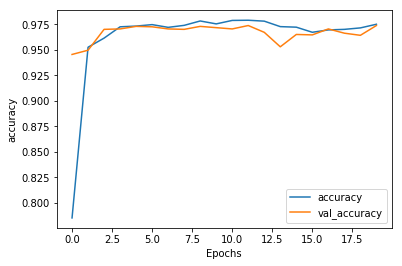

In [0]:
plot_graphics(history, 'accuracy')

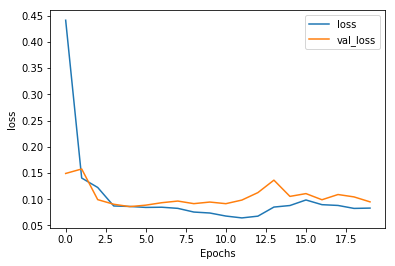

In [0]:
plot_graphics(history, 'loss')

In [11]:
if (env_url/'tokenizer.pickle').exists():
  tokenizer = load_tokenizer(env_url/'tokenizer.pickle')  
if (env_url/'rnn-simple-lstm-usrecog.h5').exists():
  model = models.load_model(format(env_url/'rnn-simple-lstm-usrecog.h5'))

def isUserStory(text):        
    token_list = tokenizer.texts_to_sequences([text])[0]
    token_list = pad_sequences([token_list], maxlen=max_lenght, padding='pre')
    #PREDICT PART OF CLASS
    class_pred = model.predict_classes(token_list, verbose = 0)   
    prob_pred = model.predict(token_list, verbose = 0)  
    return class_pred, prob_pred;

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
test_examples = [
  "As a developer, I want to implement tests",
  "As a cat, i want",
  "As a cat, i want to be fed",
  "As a dog, i want to be washed",
  "As a tester, I want to implement tests so i can assure the softwares quality",
  "As a cat, I want to implement tests so i can assure the softwares quality",
  "as an administrator i want a gui admin for configuration options",
  "As a CONNECT administrator or security officer, I want to view audit events via the System Admninistration module so that I can monitor the audit logs and events",
  "A tester want to implement tests so he can assure the software quality",
  "An administrator will audit event via the system administration module",
  "An admnistrtor will audit event via the system administration module",
  "As a bug, I want reports so it can be check",
  "As a system, I want to be able in the all time",
  "An developer build should take less than 5 minutes",
  "As a developer the default build should take less than 5 minuts",
  "As a IA tester, I want to wrtie with ortografics errors to test efficiency",
  "I want a developer as much as good tester so I have a good team"
]

print("#####Text to analize -> [probability of being an userstory]#####") 
for ex in test_examples:
  class_pred, prob_pred =  isUserStory(ex)
  print(ex + "->" + format(prob_pred))

#####Text to analize -> [probability of being an userstory]#####
As a developer, I want to implement tests->[[0.8430052]]
As a cat, i want->[[0.00274729]]
As a cat, i want to be fed->[[0.62392956]]
As a dog, i want to be washed->[[0.62392956]]
As a tester, I want to implement tests so i can assure the softwares quality->[[0.9971052]]
As a cat, I want to implement tests so i can assure the softwares quality->[[0.9971052]]
as an administrator i want a gui admin for configuration options->[[0.86563605]]
As a CONNECT administrator or security officer, I want to view audit events via the System Admninistration module so that I can monitor the audit logs and events->[[0.99858165]]
A tester want to implement tests so he can assure the software quality->[[0.00010814]]
An administrator will audit event via the system administration module->[[0.00043275]]
An admnistrtor will audit event via the system administration module->[[0.0004372]]
As a bug, I want reports so it can be check->[[0.46495476]